In [1]:
!git clone https://github.com/misbah4064/age_and_gender_detection.git
%cd age_and_gender_detection

Cloning into 'age_and_gender_detection'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 11 (delta 1), reused 0 (delta 0), pack-reused 9
Receiving objects: 100% (11/11), 1.33 MiB | 5.14 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/age_and_gender_detection


In [2]:
# Downloading pretrained data and unzipping it
!gdown https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
# https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
!unzip modelNweight.zip

Downloading...
From (original): https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS
From (redirected): https://drive.google.com/uc?id=1_aDScOvBeBLCn_iv0oxSO8X1ySQpSbIS&confirm=t&uuid=b699fe3c-4f70-4fbe-ae34-56b645f5a72a
To: /content/age_and_gender_detection/modelNweight.zip
100% 86.2M/86.2M [00:00<00:00, 88.8MB/s]
Archive:  modelNweight.zip
   creating: modelNweight/
  inflating: modelNweight/age_deploy.prototxt  
  inflating: modelNweight/age_net.caffemodel  
  inflating: modelNweight/gender_deploy.prototxt  
  inflating: modelNweight/gender_net.caffemodel  
  inflating: modelNweight/opencv_face_detector.pbtxt  
  inflating: modelNweight/opencv_face_detector_uint8.pb  


In [3]:
# Import required modules
import cv2 as cv
import math
import time
from google.colab.patches import cv2_imshow

def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "modelNweight/opencv_face_detector.pbtxt"
faceModel = "modelNweight/opencv_face_detector_uint8.pb"

ageProto = "modelNweight/age_deploy.prototxt"
ageModel = "modelNweight/age_net.caffemodel"

genderProto = "modelNweight/gender_deploy.prototxt"
genderModel = "modelNweight/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)

# Padding around the detected face
padding = 10

# Define the function to perform age and gender detection
def age_gender_detector(frame):
    # Read frame
    t = time.time()
    frameFace, bboxes = getFaceBox(faceNet, frame)

    # Check if any faces are detected
    if not bboxes:
        print("No human face detected in the image.")
        return frame

    for bbox in bboxes:
        # print(bbox)
        face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

        blob = cv.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

        # Predict gender
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]

        # Predict age
        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        # Print predictions for debugging
        print(f"Predicted Gender: {gender}, Confidence: {genderPreds[0].max()}")
        print(f"Predicted Age: {age}, Confidence: {agePreds[0].max()}")

        # Label the detected face
        label = "{},{}".format(gender, age)
        cv.putText(frameFace, label, (bbox[0], bbox[1]-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv.LINE_AA)

    return frameFace

Predicted Gender: Male, Confidence: 0.9999727010726929
Predicted Age: (25-32), Confidence: 0.8929904103279114


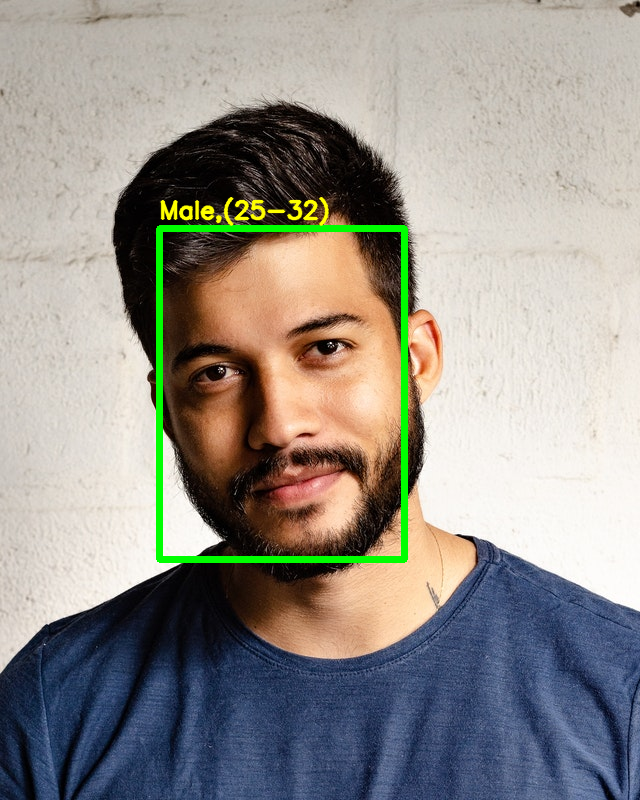

In [6]:
input = cv.imread("image.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

No human face detected in the image.


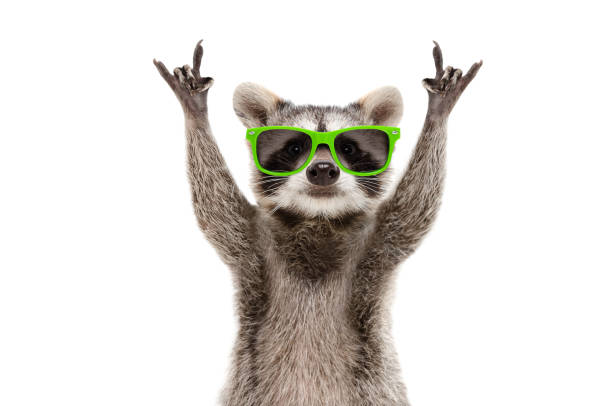

In [7]:
input = cv.imread("animal.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

Predicted Gender: Male, Confidence: 0.9999759197235107
Predicted Age: (60-100), Confidence: 0.9613471031188965


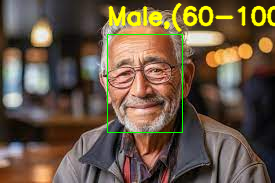

In [20]:
input = cv.imread("images (11).jpeg")
output = age_gender_detector(input)
cv2_imshow(output)

Predicted Gender: Female, Confidence: 0.9741365909576416
Predicted Age: (25-32), Confidence: 0.7578294277191162


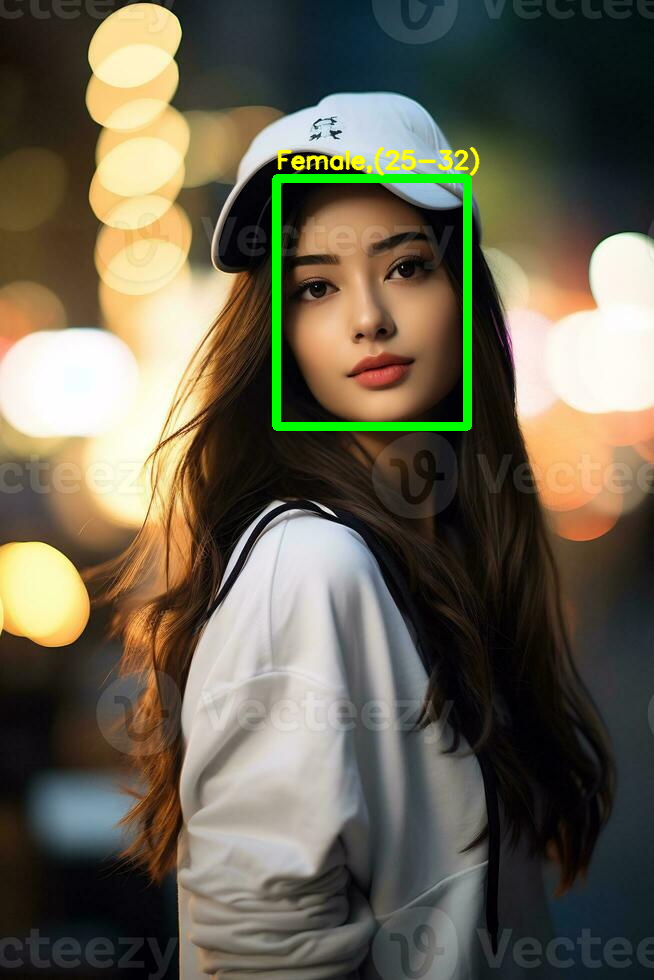

In [8]:
input = cv.imread("girl.jpg")
output = age_gender_detector(input)
cv2_imshow(output)

Predicted Gender: Male, Confidence: 0.9993403553962708
Predicted Age: (0-2), Confidence: 0.9867477416992188


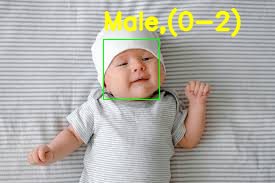

In [9]:
input = cv.imread("images (7).jpeg")
output = age_gender_detector(input)
cv2_imshow(output)

Predicted Gender: Female, Confidence: 0.9935344457626343
Predicted Age: (4-6), Confidence: 0.9250944256782532


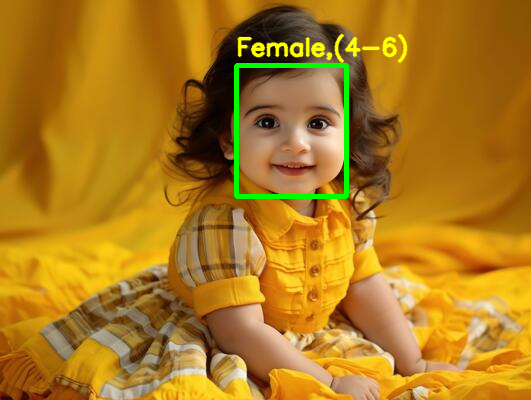

In [12]:
input = cv.imread("baby.jpg")
output = age_gender_detector(input)
cv2_imshow(output)